# Load in previously trained Logistic Regression model and classify unknown samples

In [250]:
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import numpy as np
#from itertools import combinations
import sys
import importlib

sys.path.append('../../scripts/')
# Contains special functions used in the script 
import GeochemFunctions as geofctns
importlib.reload(geofctns)

import GeochemPlotting as geoplots
importlib.reload(geoplots)

!pwd

/Users/leif/gitrepos/learngeochem/notebooks/Hampton_CRB


In [253]:

###Classify at formation level
# filename = 'CRB_Formation_trainedon_100pct.pkl'
# datalabelname = 'CRB_Formation_labels.pkl'
# classlabels = 'FormationLookupTable.pkl'

####Classify at member
#filename = 'CRB_Member_trainedon_100pct.pkl'
filename = 'CRB_Member_trainedon_100pct_maximize_elements.pkl'
#datalabelname = 'CRB_Member_labels.pkl'
datalabelname = 'CRB_Member_labels_maximize_elements.pkl'
classlabels = 'MemberLookupTable.pkl'

featurelabels = 'TrainingDataFeatures.pkl'

# load the model from disk
CRB_model = pickle.load(open(filename, 'rb'))

CRB_feature_labels = pickle.load(open(datalabelname, 'rb'))
CRB_class_labels = pickle.load(open(classlabels, 'rb'))

trainingdata_labels = pickle.load(open(featurelabels, 'rb'))
print(trainingdata_labels)
print(CRB_class_labels)
CRB_feature_labels

Index(['SiO2', 'TiO2', 'Al2O3', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'P2O5',
       'Ni', 'Cr', 'Sc', 'Ba', 'Rb', 'Sr', 'Zr'],
      dtype='object')
    MemberID            Member  NumSamples
0          0       LowerSteens          61
1          1       UpperSteens          16
2          2          LogCreek          17
3          3         FallCreek           5
4          4       AmericanBar          96
5          5         RockCreek          65
6          6   BuckhornSprings          20
7          7        BirchCreek          17
8          8       TeepeeButte          31
9          9        Rogersburg          23
10        10     SkeletonCreek           5
11        11       CenterCreek          10
12        12      KendrikGrade          27
13        13        BradyGulch           2
14        14       DowneyGulch          59
15        15         FryePoint           5
16        16        ChinaCreek          40
17        17       HoskinGulch           6
18        18  ColdSpringsRidge     

0        0
89       0
88       0
87       0
86       0
        ..
7960    46
7963    46
7964    46
7961    46
7962    46
Name: MemberID, Length: 4623, dtype: int64

## Load the data we want to classify here

In [254]:
#CRB database that we want to classify
datafile = '/Users/leif/gitrepos/learngeochem/data/CRB/CRB_undifferentiated_2024.csv'
#datafile = '/Users/leif/gitrepos/learngeochem/data/CRB/HughesDataAll_2024.csv'

mx_data_=pd.read_csv(datafile, header=0)

#drop columns to match the training dataset
mx_features_ = mx_data_[trainingdata_labels]
mx_features_ = mx_features_.dropna(axis=0, how='any')

print(mx_features_.head(0))

Empty DataFrame
Columns: [SiO2, TiO2, Al2O3, MnO, MgO, CaO, Na2O, K2O, P2O5, Ni, Cr, Sc, Ba, Rb, Sr, Zr]
Index: []


In [255]:
#standard naming
df2 = mx_features_

#make ratios between every feature and every other feature  
df2 = pd.DataFrame(geofctns.makeratios(df2))

#power transform to normalize values
df2 = geofctns.normalizedata(df2,'powert')

print(np.shape(df2))

(1570, 136)


In [256]:
#make classification prediction using trained model
unknown_data = df2

#make a prediction based on highest probability for each sample
prediction=CRB_model.predict(unknown_data)

# Loop over prediction vector to find the labels 
matching_rows = []
for val in prediction:
    matching_rows.append(CRB_class_labels.loc[CRB_class_labels['MemberID'] == val, 'Member'].item())

prediction=pd.DataFrame({'ID': prediction, 'label': matching_rows})
                  
probability=CRB_model.predict_proba(unknown_data)
probability=pd.DataFrame(probability) 
probability.columns = CRB_class_labels.Member

#Clean up the probabilities by setting any probability < threshold equal to zero
lowerLimit = .01

#we will set any value less than 'lowerlimit' to zero for ease in visualization. 
probability_clean = probability.copy()
probability_clean[probability_clean<lowerLimit]=0

#print(PredictedName)
print(prediction)  
print(probability)
print(probability_clean)

ValueError: Length mismatch: Expected axis has 47 elements, new values have 46 elements

## Plotting 

In [257]:
#first, redefine the generic dataframe df to be associated with output from classified
df = probability

n=10
data = np.array(df.iloc[n,:].values)

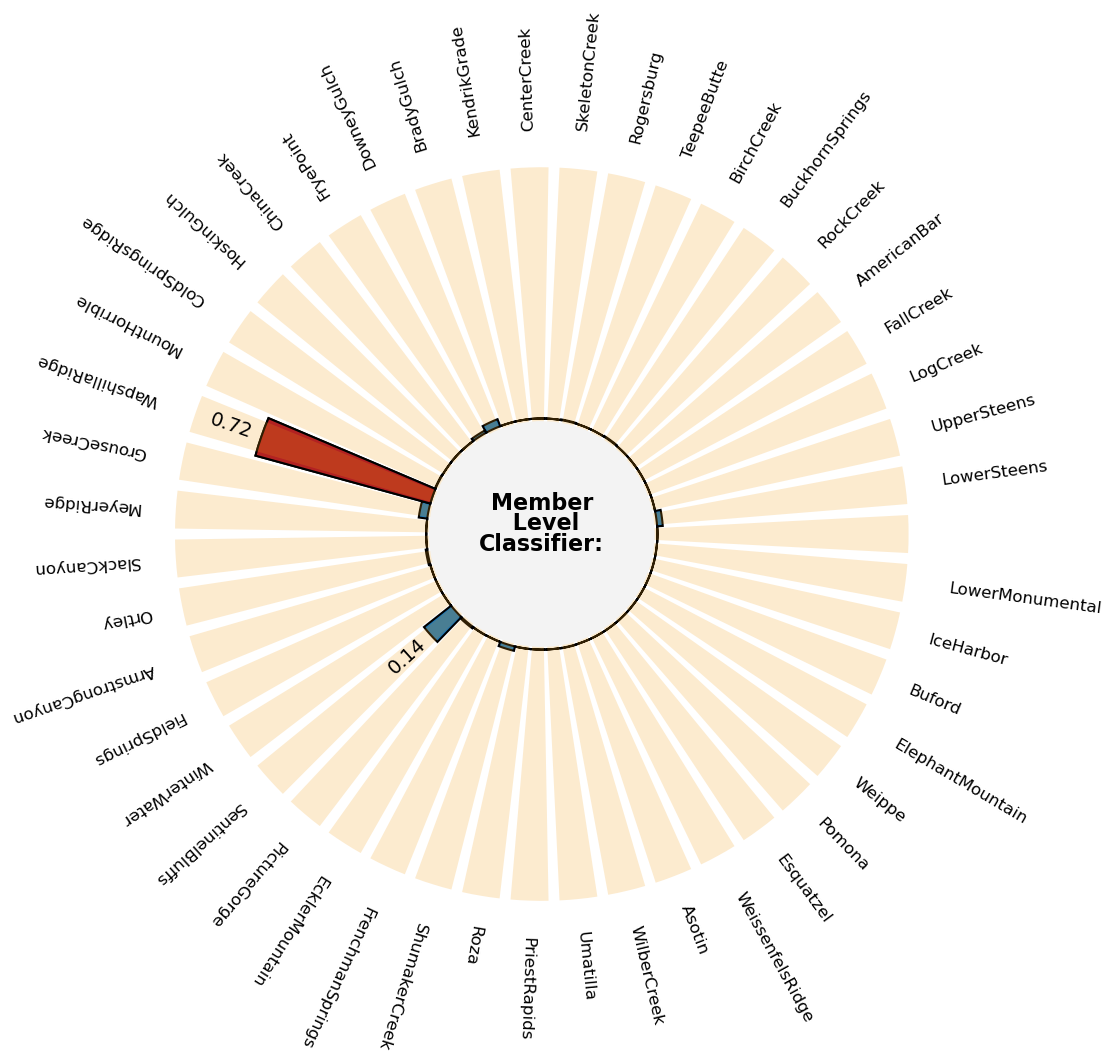

In [258]:
#single panel plot for one sample
fig=plt.figure(figsize=(10,10))

    # plot polar axis
ax = plt.subplot(111, polar=True)

#sample = df['Sample'][n]
centerlabel="Member\n Level\nClassifier:\n"  
classlabels = CRB_class_labels.Member

geoplots.plot_single_classification(data,classlabels,fig,ax,centerlabel,12,lowerLimit)

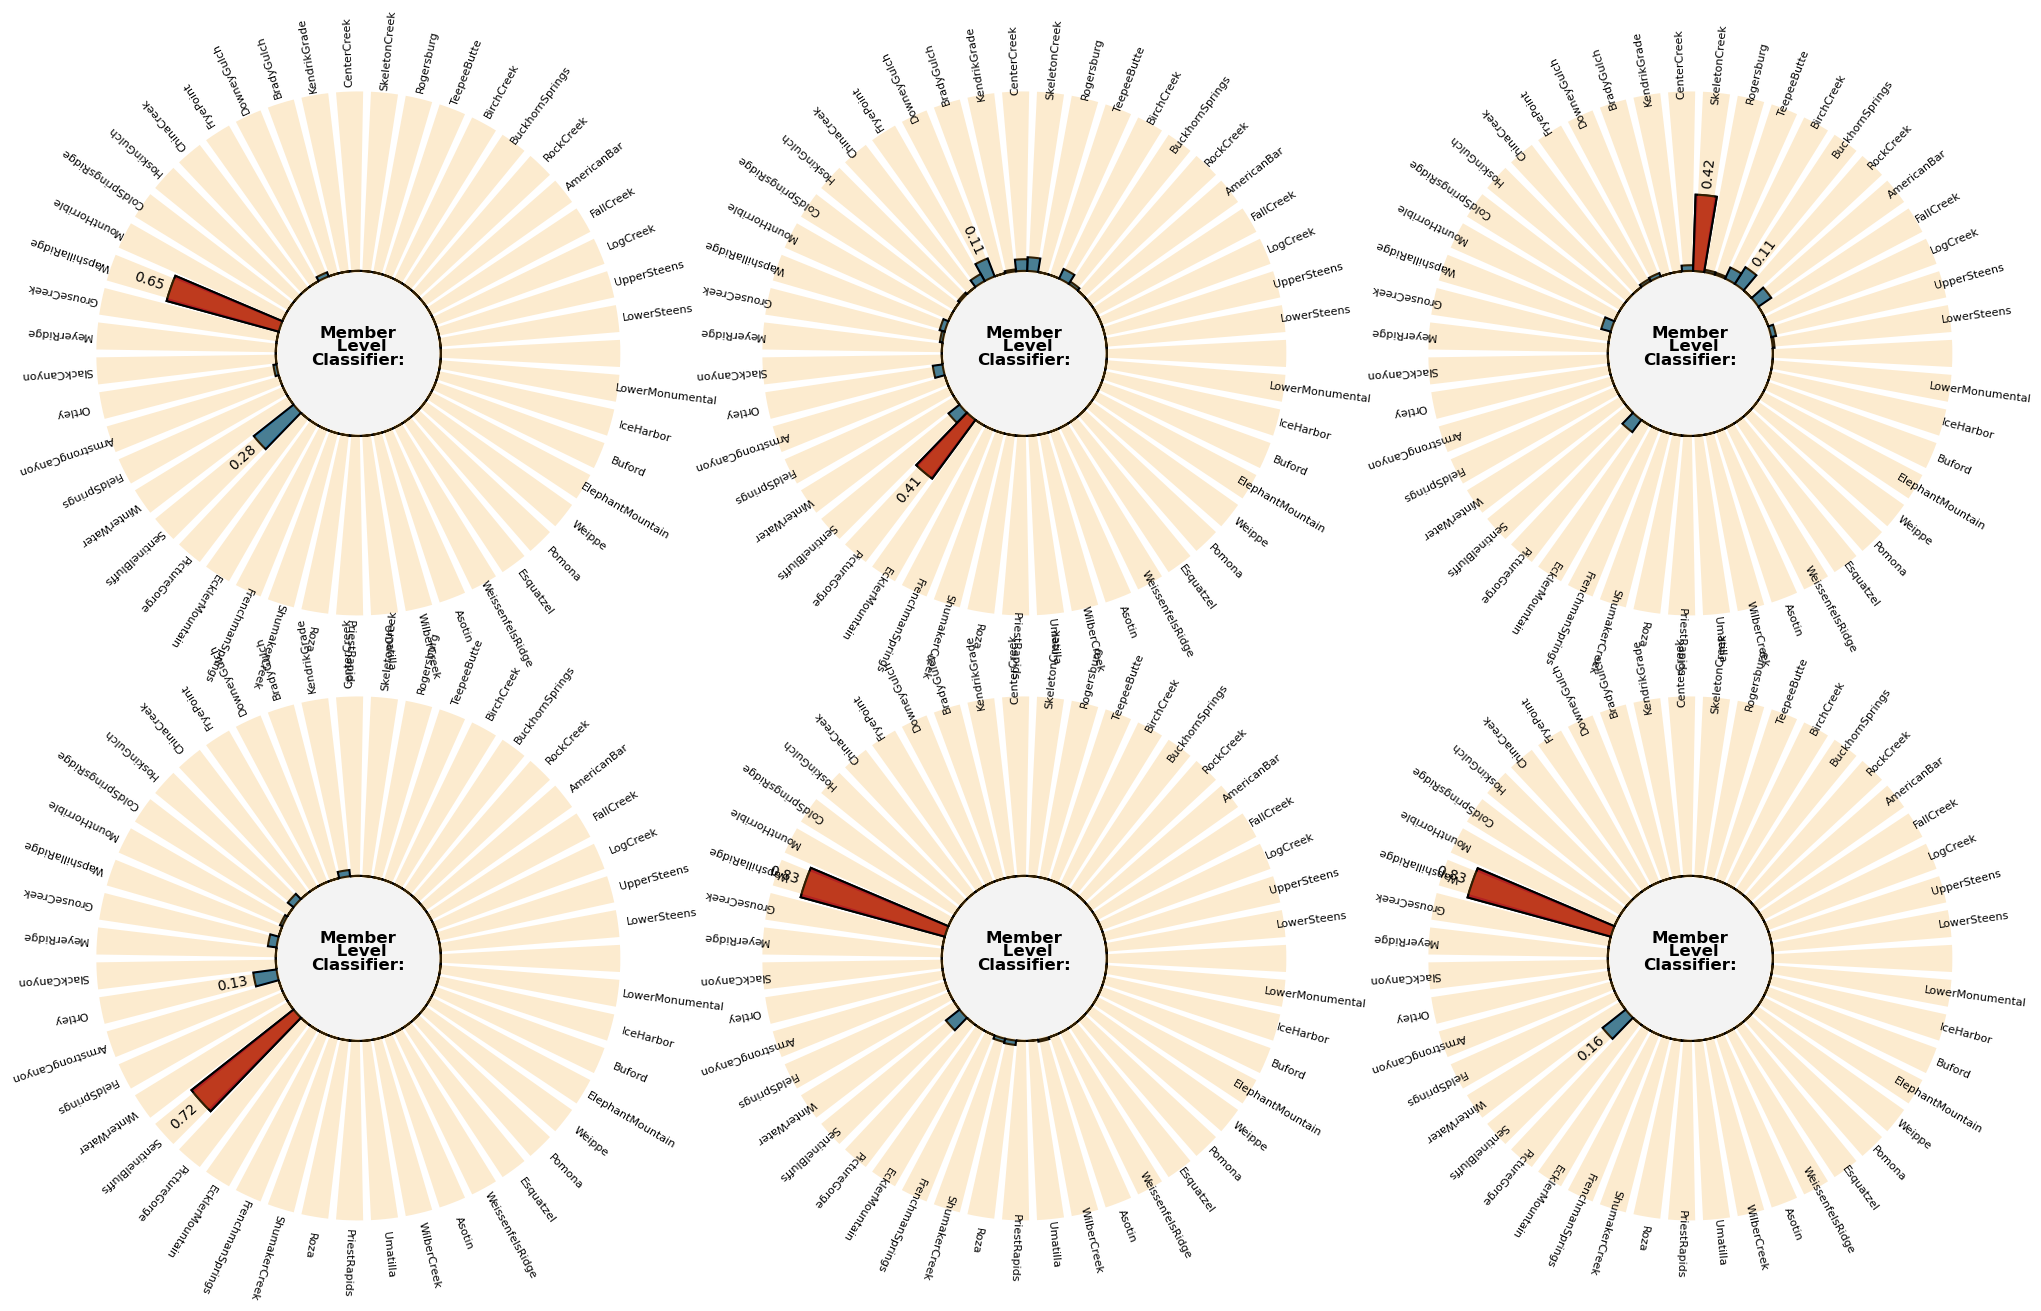

In [259]:
#multiple panel plot
nrow = 2
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(25, 15), subplot_kw={"projection": "polar"})
fig.patch.set_facecolor("white")

# Define the slices used to iterate through 'axes'.
# It iterates in a rowwise manner.
# It starts in the first row, and iterates over all the columns of that row
# from left to right, then it goes to the next row and does the same.
SLICES = [(i, j) for i in range(nrow) for j in range(ncol)]

#generate list of indices to call from our dataframe of classified samples
#total length needs to be equal to or greater than nrow*ncol
lower=20
upper=44
nidx = [i for i in range(lower,upper)]

for slice_ in SLICES:
    # Select axis
    ii = (slice_[1]+1) + ncol*slice_[0]
    
    ax = axes[slice_[0],slice_[1]]
    
    # Select indexes corresponding to the passwords in this category
    #test dataset
    n=nidx[ii-1]
    
    data = np.array(df.iloc[n,:].values)

    # Set the coordinates limits
    #upperLimit = 1
    lowerLimit = .01

    #we will set any value less than 'lowerlimit' to zero for ease in visualization. 
    data[data<lowerLimit]=0
    
    #sample number label
    centerlabel="Member\n Level\nClassifier:\n"  
    classlabels = CRB_class_labels.Member
    
    geoplots.plot_single_classification(data,classlabels,fig,ax,centerlabel,8,lowerLimit)
       
# Adjust space between subplots.
# 'wspace=0' leaves no horizontal space between subplots.
# 'hspace=0' leaves no vertical space between subplots.
fig.subplots_adjust(wspace=0.1, hspace=0.1)

## Plot up the distribution of classifications for many samples

In [260]:
#first extract the highest probability for each sample
print(df.shape[0])
maxdat = []#np.empty([df.shape[0]])
classmax = []#np.empty([df.shape[0]])

std_nm = []
mean_nm = []

for i in range(0,df.shape[0]):
    
    data = np.array(df.iloc[i,:].values)
    maxprob = np.amax(data) #most likely classification
    idx = np.argmax(data) #where in the array this occurs
    
    nthresh = 0.01 #threshold probability
    #q3, q1 = np.percentile(data[data>nthresh], [75 ,25])
    #iqr = q3 - q1 #interquartile range of probabilities
    D=(data[(data!=maxprob)&(data>nthresh)])
    
    if D.size != 0:
        std_ofnotmax = np.std(data[(data>nthresh) & (data!=maxprob)])
        mean_ofnotmax = np.mean(data[(data>nthresh) & (data!=maxprob)])
    else:
        std_ofnotmax = 0;
        mean_ofnotmax = 0;
        
    maxdat.append(maxprob)
    classmax.append(idx)
    std_nm.append(std_ofnotmax)
    mean_nm.append(mean_ofnotmax)


1570


In [261]:
#now plot up distributions 
#histmax, bin_edgesmax = np.histogram(classmax,bins=len(GRBname))

maxmean=[]
max_nm_mean=[]
histmax=[]

#now compute the stats of probability per class
for jj in range(0,len(classlabels)):
    
    maxsub = geofctns.find(classmax,maxdat,jj) 
    max_nmsub = geofctns.find(classmax,mean_nm,jj) 
    histmx = geofctns.find(classmax,[],jj)
    
    if len(maxsub) > 0:   
        #print(jj,maxsub)
        histmax.append(len(histmx))
        maxmean.append(np.mean(maxsub))
        max_nm_mean.append(np.mean(max_nmsub))
    else:
        histmax.append(0)
        maxmean.append(0)
        max_nm_mean.append(0)

print(histmax)
print(maxmean)
print(np.median(maxmean))

[16, 3, 7, 3, 41, 25, 25, 23, 16, 13, 11, 33, 27, 0, 6, 0, 15, 0, 6, 3, 244, 0, 106, 0, 15, 2, 0, 31, 76, 371, 38, 42, 101, 11, 10, 66, 33, 4, 38, 17, 4, 5, 8, 42, 3, 13]
[0.5894424054940526, 0.5682403637434444, 0.556921779493906, 0.6327894264203427, 0.658085070904068, 0.7895972309120388, 0.4023072789127613, 0.4600719226914401, 0.5893813820252103, 0.571654303087593, 0.3073544962652886, 0.6562797543624868, 0.7272728541655616, 0, 0.3198674740509642, 0, 0.6510452346582739, 0, 0.5018277005826052, 0.4227593231097339, 0.6621394101179557, 0, 0.9397663847211811, 0, 0.5385450477263913, 0.43803075275069003, 0, 0.9378028100587775, 0.5405752182362182, 0.7054285983359306, 0.6673218846463206, 0.6640366505897313, 0.7630594826268907, 0.9386095517315883, 0.587078045222609, 0.8699288363947959, 0.9611354669985066, 0.9730327447232003, 0.7735411551654413, 0.6788994394916713, 0.539328441820544, 0.7548528626520208, 0.8769326777018064, 0.6316783475499641, 0.8903945704463933, 0.9747499760911086]
0.632233886985

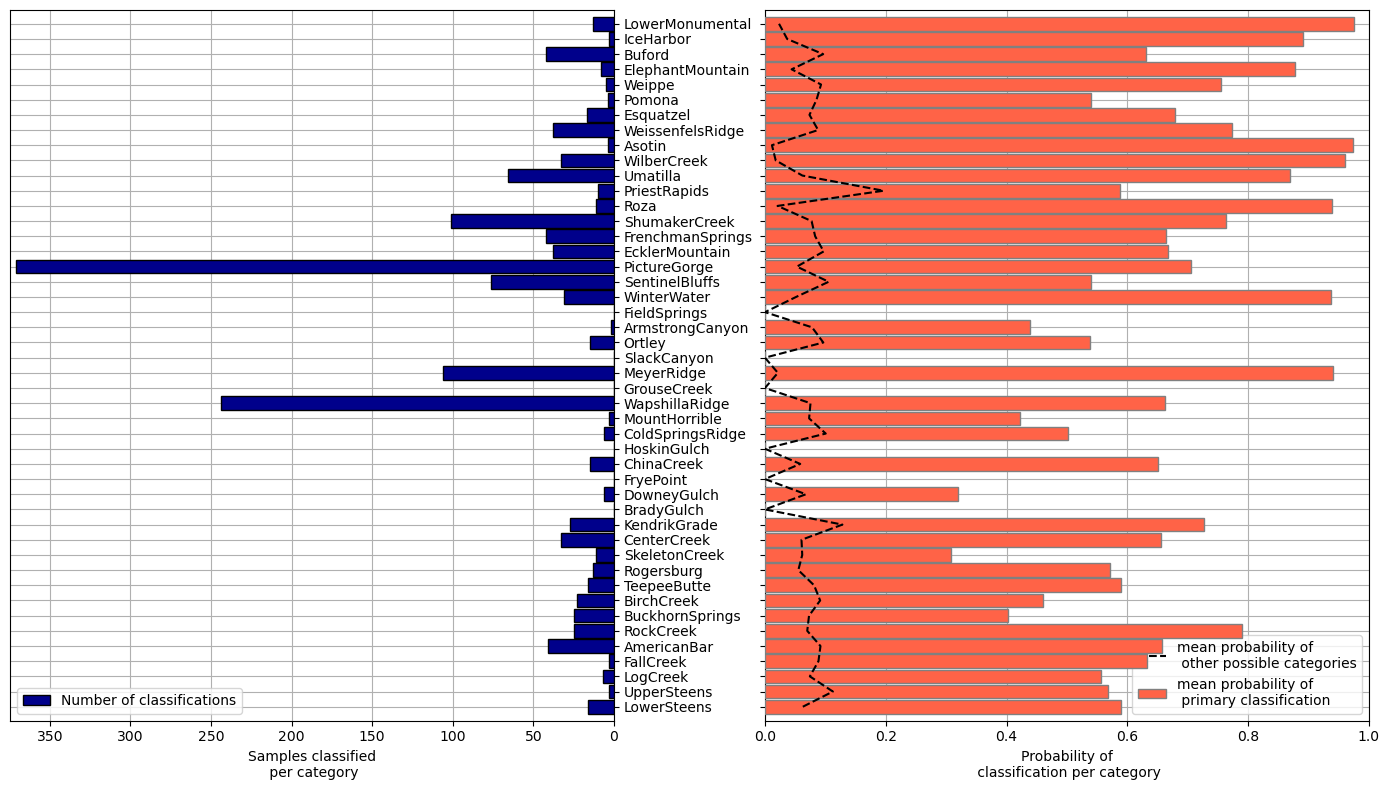

In [262]:
y = np.arange(np.array(histmax).size)

Leg = ['mean(max\n probabilities in class)','mean(non-max\n probabilities in class)']

fig, axes = plt.subplots(ncols=2, sharey=True,figsize=(14, 8))
axes[0].barh(y, histmax,0.9, align='center', color='darkblue', zorder=10, edgecolor="black",label='Number of classifications')
axes[0].set(xlabel='Samples classified\n per category')
axes[0].legend(loc='lower left')

axes[1].barh(y, maxmean,0.9, align='center', color='tomato', zorder=10,edgecolor="gray",label='mean probability of\n primary classification')
axes[1].plot(max_nm_mean,y,'k--',zorder=10,label='mean probability of\n other possible categories')
axes[1].set(xlabel='Probability of\n classification per category')
axes[1].legend(loc='lower right')

axes[1].set_xlim([0 ,1])

axes[0].invert_xaxis()
axes[0].set(yticks=y, yticklabels=classlabels)
axes[0].yaxis.tick_right()

for ax in axes.flat:
    ax.margins(.01)
    ax.grid(True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.25)
#plt.show()
#fig.savefig('Classification_Distribution.png')